In [1]:
import os
import openai
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv()) 
openai.api_key  = os.getenv('OPENAI_API_KEY')

In [2]:
# This is utility switch. Turns on more logging.
log_state_data = True

### AgentState

In [3]:
import functools
import operator
from typing import Annotated
from typing import Sequence, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage

#from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

#from langgraph.graph import END, StateGraph, START


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # This is storing the initial question from the user
    task: str
    # This is storing the guid to look for
    guid: str        
    # Will be true if log has error    
    logerror: bool
    # This stores the composition of the application
    # This should probably be a python dict at some point
    composition: str    
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str
    # The 'summary' field contains the final summary
    summary: str    


In [4]:
GETANSIBLEGUID_PROMPT = """You are an expert at determining the guid from a query.\
Find out the guid and just return the guid and nothing else. """

In [5]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

def getAnsiblelog_node(state: AgentState):
    
    if (log_state_data):
        print("*************inside getAnsiblelog_node********************")
        for key in state:
            print(key," : ",state[key])
        print("*********************************")
    
    msg = state['task']
    
    messages = [
        SystemMessage(content=GETANSIBLEGUID_PROMPT), 
        HumanMessage(content=msg)
        
   ]

    model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
    response = model.invoke(messages)

    return {"task": msg, "guid": [response.content], "logerror": True}

In [6]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

def sendSlack_node(state: AgentState):
    
    if (log_state_data):
        print("*************inside sendSlack_node********************")
        for key in state:
            print(key," : ",state[key])
        print("*********************************")
    
    msg = "slack sent"
    

    return {"summary": msg}

In [7]:
from langgraph.graph import END, StateGraph, START
workflow = StateGraph(AgentState)
workflow.add_node("Error_Detect",getAnsiblelog_node)
workflow.add_node("Slack",sendSlack_node)
workflow.add_edge("Slack", END)

# Finally, add entrypoint
workflow.add_edge(START, "Error_Detect")

In [8]:
def should_continue(state):
    if state["logerror"] == False:
        return END
    return "Slack"

In [9]:
workflow.add_conditional_edges(
    "Error_Detect", 
    should_continue, 
    {END: END, "Slack": "Slack"}
)

In [10]:
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver.from_conn_string(":memory:")


#graph = workflow.compile()
graph = workflow.compile(checkpointer=memory)

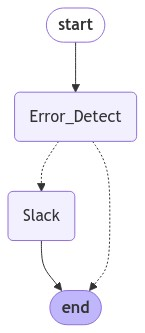

In [11]:
from IPython.display import Image, display
#from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeColors
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [12]:
thread = {"configurable": {"thread_id": "1"}}

    
for s in graph.stream(
    #{"messages": [HumanMessage(content="What about guid 123456")]},
    {"task": "Find out the health of a job with id 123456."},
    #{"recursion_limit": 4},
    thread
    ):
    if "__end__" not in s:
        print(s)
        print("----")

*************inside getAnsiblelog_node********************
task  :  Find out the health of a job with id 123456.
guid  :  None
logerror  :  None
composition  :  None
messages  :  []
next  :  None
summary  :  None
*********************************
{'Error_Detect': {'task': 'Find out the health of a job with id 123456.', 'guid': ['123456'], 'logerror': True}}
----
*************inside sendSlack_node********************
task  :  Find out the health of a job with id 123456.
guid  :  ['123456']
logerror  :  True
composition  :  None
messages  :  []
next  :  None
summary  :  None
*********************************
{'Slack': {'summary': 'slack sent'}}
----
